In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/ML_dataset')

image_size = (224, 224)
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

validate_datagen = ImageDataGenerator(rescale=1./255)

# Loading training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Loading validation data
validation_generator = validate_datagen.flow_from_directory(
    os.path.join(data_dir, 'validate'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 603 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [ ]:
print("Class indices:", train_generator.class_indices)
print("Total number of samples:", train_generator.samples)
class_counts = {label: sum(1 for i in range(len(train_generator.labels)) if train_generator.labels[i] == label)
                for label in range(len(train_generator.class_indices))}
print("Number of images per class:", class_counts)

print("\nClass indices:", validation_generator.class_indices)
print("Total number of samples:", validation_generator.samples)
class_counts = {label: sum(1 for i in range(len(validation_generator.labels)) if validation_generator.labels[i] == label)
                for label in range(len(validation_generator.class_indices))}
print("Number of images per class:", class_counts)

Class indices: {'adidas': 0, 'converse': 1, 'nike': 2}
Total number of samples: 603
Number of images per class: {0: 201, 1: 201, 2: 201}

Class indices: {'adidas': 0, 'converse': 1, 'nike': 2}
Total number of samples: 90
Number of images per class: {0: 30, 1: 30, 2: 30}


In [ ]:
# Creating a transfer learning model (Using ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-15]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Building the complete model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,777,091 (94.52 MB)

 Trainable params: 6,705,667 (25.58 MB)

 Non-trainable params: 18,071,424 (68.94 MB)

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
]

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3298 - loss: 1.6274

19/19 ━━━━━━━━━━━━━━━━━━━━ 174s 8s/step - accuracy: 0.3313 - loss: 1.6242 - val_accuracy: 0.3333 - val_loss: 1.1503 - learning_rate: 1.0000e-04
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.3937 - loss: 1.4468 - val_accuracy: 0.3333 - val_loss: 1.1304 - learning_rate: 1.0000e-04
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.4327 - loss: 1.3256 - val_accuracy: 0.3333 - val_loss: 1.1096 - learning_rate: 1.0000e-04
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.4536 - loss: 1.2711 - val_accuracy: 0.3333 - val_loss: 1.0868 - learning_rate: 1.0000e-04
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4379 - loss: 1.3146

19/19 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.4384 - loss: 1.3134 - val_accuracy: 0.3667 - val_loss: 1.0763 - learning_rate: 1.0000e-04
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4549 - loss: 1.1794

19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.4551 - loss: 1.1814 - val_accuracy: 0.3778 - val_loss: 1.0622 - learning_rate: 1.0000e-04
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4610 - loss: 1.2621

19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.4614 - loss: 1.2585 - val_accuracy: 0.5556 - val_loss: 1.0567 - learning_rate: 1.0000e-04
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.4557 - loss: 1.1808 - val_accuracy: 0.5000 - val_loss: 1.0605 - learning_rate: 1.0000e-04
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.4582 - loss: 1.2080 - val_accuracy: 0.4444 - val_loss: 1.0522 - learning_rate: 1.0000e-04
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.5325 - loss: 1.1342 - val_accuracy: 0.4333 - val_loss: 1.0520 - learning_rate: 1.0000e-04
Epoch 11/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - accuracy: 0.4762 - loss: 1.1485 - val_accuracy: 0.4556 - val_loss: 1.0373 - learning_rate: 1.0000e-04
Epoch 12/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.5709 - loss: 1.0837 - val_accuracy: 0.5000 - val_loss: 1.0103 - learning_rate: 1.0000e-04
Epoch 13/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 146s 8s/step - accuracy: 0.5005 - loss:

19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.5485 - loss: 0.9874 - val_accuracy: 0.5889 - val_loss: 0.9986 - learning_rate: 1.0000e-04
Epoch 15/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5146 - loss: 1.0802 - val_accuracy: 0.5444 - val_loss: 0.9948 - learning_rate: 1.0000e-04
Epoch 16/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.5013 - loss: 1.0943 - val_accuracy: 0.5222 - val_loss: 0.9983 - learning_rate: 1.0000e-04
Epoch 17/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.5239 - loss: 1.0103 - val_accuracy: 0.5444 - val_loss: 0.9820 - learning_rate: 1.0000e-04
Epoch 18/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5135 - loss: 1.0664 - val_accuracy: 0.5667 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 19/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - accuracy: 0.4961 - loss: 1.0677 - val_accuracy: 0.5444 - val_loss: 0.9883 - learning_rate: 1.0000e-04
Epoch 20/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.5336 - los

19/19 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.5326 - loss: 1.0092 - val_accuracy: 0.6778 - val_loss: 0.8690 - learning_rate: 1.0000e-04
Epoch 24/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.5179 - loss: 1.0138 - val_accuracy: 0.6444 - val_loss: 0.8629 - learning_rate: 1.0000e-04
Epoch 25/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.5564 - loss: 0.9850 - val_accuracy: 0.6333 - val_loss: 0.8550 - learning_rate: 1.0000e-04


In [ ]:
model.save('shoe_classifier.h5')

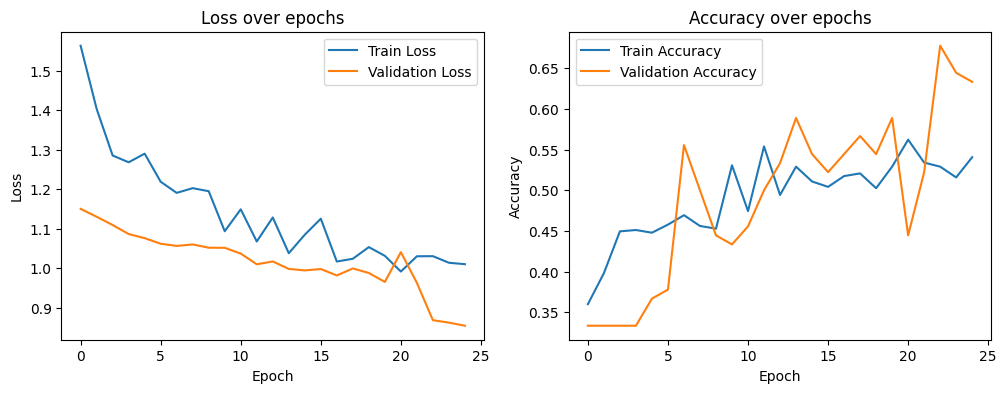

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')
plt.show()

In [8]:
# The following block is for loading and testing model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

best_model = load_model('/content/drive/MyDrive/best_model.h5') # download best_model.h5 storage location
print("\nEvaluating best model on validation set...")

data_dir = pathlib.Path('/content/drive/MyDrive/ML_dataset/validate') # validate data storage location
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = best_model.evaluate(validation_generator)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")


Evaluating best model on validation set...
Found 90 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.7139 - loss: 0.8505

Validation Accuracy: 67.78%
